<a href="https://colab.research.google.com/github/dtian09/MLI_Training/blob/master/ViT_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall -y torch torchvision torchaudio

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124


In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 111.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 128.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 955.6/9

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn                    # For building neural networks
import torch.optim as optim              # For optimization algorithms
import torch.nn.functional as F          # For activation functions and other utilities
from torchvision import datasets, transforms  # For loading and transforming datasets
from torchvision.transforms.v2 import ToImage, ToDtype
from torch.utils.data import DataLoader, random_split  # For data loading and batching
import matplotlib.pyplot as plt          # For plotting
import numpy as np
import math
#import fiftyone as fo

# Check if GPU is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # Define transformations for the training and testing data
# transform = transforms.Compose([
#     transforms.ToTensor(),                # Convert images to PyTorch tensors
#     transforms.Normalize((0.5,), (0.5,))  # Normalize images to [-1, 1]
# ])

In [ ]:
# # Download and load the training data - I have amended this to be for MNIST rather than Fashion MNIST
# train_dataset = datasets.MNIST(
#     root='./data', train=True, download=True, transform=transform)

# # Download and load the test data
# test_dataset = datasets.MNIST(
#     root='./data', train=False, download=True, transform=transform)

In [ ]:
#Train/Test/Validation Split

In [ ]:
# 1. Load and split MNIST into training and validation sets
def load_and_split_mnist(validation_split=0.2, batch_size=16):
    # Load MNIST dataset
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    # Calculate sizes for split
    val_size = int(len(mnist_train) * validation_split)
    train_size = len(mnist_train) - val_size

    # Split dataset
    train_dataset, val_dataset = random_split(mnist_train, [train_size, val_size])

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader


In [ ]:

# 2. Create a function to divide images into patches
def image_to_patches(images, patch_size=7):
    """
    Convert batch of images into patches

    Args:
        images: tensor of shape [batch_size, channels, height, width]
        patch_size: size of each square patch

    Returns:
        patches: tensor of shape [batch_size, num_patches, patch_size*patch_size]
    """
    batch_size, channels, height, width = images.shape

    # Calculate number of patches in each dimension
    patches_h = height // patch_size
    patches_w = width // patch_size

    # Reshape images to extract patches
    # First reshape to separate patches
    patches = images.view(batch_size, channels, patches_h, patch_size, patches_w, patch_size)

    # Permute dimensions to group patch dimensions
    patches = patches.permute(0, 2, 4, 1, 3, 5)

    # Reshape to [batch_size, num_patches, channels*patch_size*patch_size]
    patches = patches.reshape(batch_size, patches_h * patches_w, channels * patch_size * patch_size)

    return patches




In [ ]:
# 3. Create a simple dimensionality reduction module
class PatchDimReducer(nn.Module):
    def __init__(self, in_features=49, out_features=32):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        # x shape: [batch_size, num_patches, patch_size*patch_size]
        return self.linear(x)

# Example usage
if __name__ == "__main__":
    # 1. Load and split the dataset
    train_loader, val_loader, test_loader = load_and_split_mnist()

    # 2. Create the dimension reducer model
    dim_reducer = PatchDimReducer(in_features=49, out_features=32)

    # Process a batch
    for images, labels in train_loader:
        # Shape of images: [batch_size, 1, 28, 28]

        # Convert images to patches
        patches = image_to_patches(images, patch_size=7)
        # Shape of patches: [batch_size, 16, 49]  (16 patches of size 7x7=49)

        # Apply dimension reduction
        reduced_patches = dim_reducer(patches)
        # Shape of reduced_patches: [batch_size, 16, 32]

        print(f"Original image shape: {images.shape}")
        print(f"Patches shape: {patches.shape}")
        print(f"Reduced patches shape: {reduced_patches.shape}")
        break

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.11MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.92MB/s]

Original image shape: torch.Size([16, 1, 28, 28])
Patches shape: torch.Size([16, 16, 49])
Reduced patches shape: torch.Size([16, 16, 32])


In [ ]:

# For visualization of the patches (optional)
def visualize_patches(image, patch_size=7):
    """Visualize the patches created from a single image"""
    import matplotlib.pyplot as plt
    import numpy as np

    # Convert to numpy and squeeze channel dimension for plotting
    image_np = image.squeeze().numpy()

    # Calculate patches per dimension
    patches_h = image_np.shape[0] // patch_size
    patches_w = image_np.shape[1] // patch_size

    # Create a figure to display the patches
    fig, axes = plt.subplots(patches_h, patches_w, figsize=(8, 8))

    # Extract and plot each patch
    for i in range(patches_h):
        for j in range(patches_w):
            patch = image_np[i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
            axes[i, j].imshow(patch, cmap='gray')
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

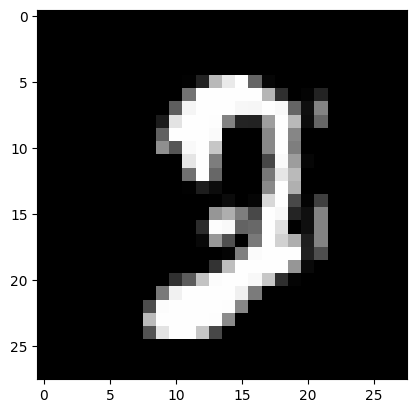

In [ ]:
# Get a batch from a dataloader
dataiter = iter(train_loader)
batch_images, batch_labels = next(dataiter)

# Access the 5th image in this batch
image_5 = batch_images[4]  # Note: zero-indexed
label_5 = batch_labels[4]
plt.imshow(image_5.squeeze(), cmap='gray')

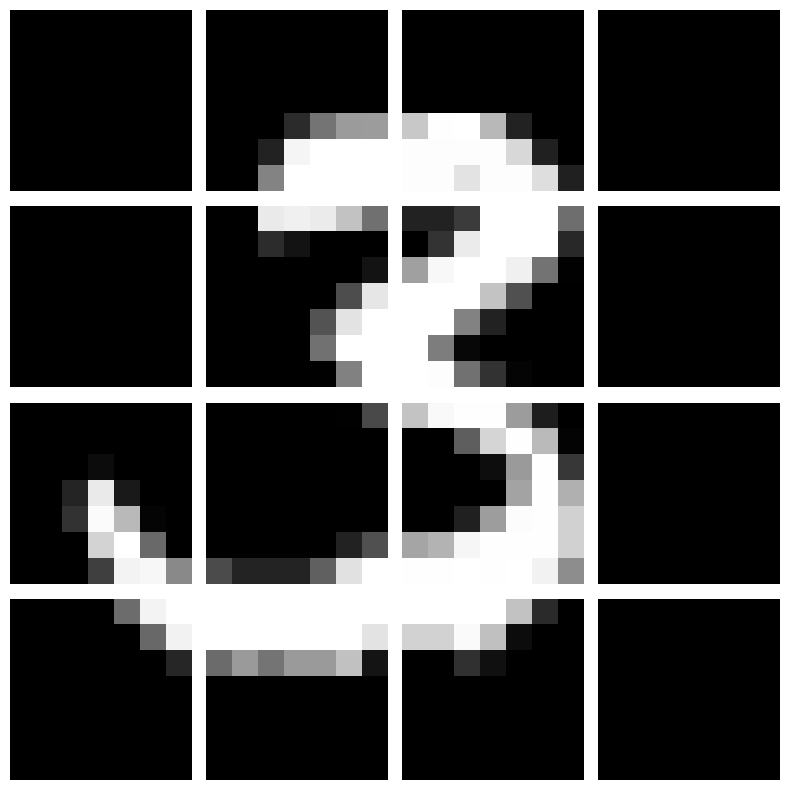

In [ ]:
visualize_patches(images[1])

In [ ]:
# For 2D image patches, you could also create a specialized version:
class LearnablePosition2DEmbedding(nn.Module):
    """
    Learnable 2D position embeddings for image patches.
    """
    def __init__(self, height, width, embed_dim):
        super().__init__()
        self.height = height
        self.width = width

        # Initialize separate embeddings for rows and columns
        # This gives the model more structure about 2D positions
        self.row_embed = nn.Parameter(torch.zeros(height, embed_dim // 2))
        self.col_embed = nn.Parameter(torch.zeros(width, embed_dim // 2))

        # Initialize with small random values
        nn.init.trunc_normal_(self.row_embed, std=0.02)
        nn.init.trunc_normal_(self.col_embed, std=0.02)

    def forward(self, x):
        """
        Add 2D position embeddings to patch embeddings
        Args:
            x: Patch embeddings of shape [batch_size, height*width, embed_dim]
        Returns:
            x with position embeddings added
        """
        batch_size = x.size(0)

        # Create 2D position embeddings
        pos_embed = torch.zeros(batch_size, self.height * self.width, x.size(2),
                                device=x.device, dtype=x.dtype)

        # Fill the position embeddings
        for i in range(self.height):
            for j in range(self.width):
                pos = i * self.width + j
                pos_embed[:, pos, :self.row_embed.size(1)] = self.row_embed[i]
                pos_embed[:, pos, self.row_embed.size(1):] = self.col_embed[j]

        return x + pos_embed

###Encoder Only Model for Digit Classification


In [ ]:
# start of with just a single encoder block and a single attention mechanism
class TransformerEncoderBlockOld(nn.Module):
    def __init__(self, embed_dim, hidden_dim=128, dropout=0.1, num_heads=1):
        super().__init__()

        # Save embedding dimension for scaling
        self.embed_dim = embed_dim
        self.head_dim = 24

        # Self-attention components
        self.query = nn.Linear(embed_dim, self.head_dim).float()
        self.key = nn.Linear(embed_dim, self.head_dim).float()
        self.value = nn.Linear(embed_dim, self.head_dim).float()

        # Output projection from attention
        self.attn_proj = nn.Linear(self.head_dim, embed_dim).float()

        # Layer normalization
        self.norm1 = nn.LayerNorm(embed_dim).float()
        self.norm2 = nn.LayerNorm(embed_dim).float()

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # MLP block
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim).float(),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim).float(),
            nn.Dropout(dropout)
        )

        # Classification head
        self.classifier = nn.Linear(embed_dim, 10).float()

    def forward(self, x):
        # Store original input for residual connection
        residual = x

        # Self-attention
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)

        print(f"I'm in the Encoder forward pass, q, k and v are of shape{q.shape}, {k.shape}, {v.shape}")

        # Attention calculation
        attn_scores = torch.bmm(q, k.transpose(1, 2)) * (self.head_dim ** -0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        attn_weights = self.dropout(attn_weights)  # Apply dropout to attention weights
        attn_output = torch.bmm(attn_weights, v)

        # Project attention output
        attn_output = self.attn_proj(attn_output)
        attn_output = self.dropout(attn_output)

        # Add residual connection and apply layer norm
        x = self.norm1(residual + attn_output)

        # MLP block with residual connection
        residual = x
        mlp_output = self.mlp(x)
        x = self.norm2(residual + mlp_output)

        # Mean pooling across patches for classification
        x = x.mean(dim=1)  # Shape: [batch_size, embed_dim]

        # Final classification layer
        logits = self.classifier(x)

        return logits

In [ ]:
# with multi-head capabilities
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim=128, dropout=0.1, num_heads=2, head_dim=24):
        super().__init__()

        # Store attention dimensions
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.total_head_dim = num_heads * head_dim

        # Combined QKV projection for all heads
        self.qkv_proj = nn.Linear(embed_dim, 3 * num_heads * head_dim).float()

        # Output projection from attention
        self.attn_proj = nn.Linear(num_heads * head_dim, embed_dim).float()

        # Store dimensions for reshaping
        self.embed_dim = embed_dim

        # Layer normalization
        self.norm1 = nn.LayerNorm(embed_dim).float()
        self.norm2 = nn.LayerNorm(embed_dim).float()

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # MLP block
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim).float(),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim).float(),
            nn.Dropout(dropout)
        )

        # Classification head
        self.classifier = nn.Linear(embed_dim, 10).float()

    def forward(self, x):
        # Store original input for residual connection
        residual = x
        batch_size, seq_len, _ = x.shape

        # Combined QKV projection
        qkv = self.qkv_proj(x)  # Shape: [batch_size, seq_len, 3 * num_heads * head_dim]

        # Reshape to separate Q, K, V and heads
        qkv = qkv.reshape(batch_size, seq_len, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # Shape: [3, batch_size, num_heads, seq_len, head_dim]

        # Unpack Q, K, V
        q, k, v = qkv[0], qkv[1], qkv[2]  # Each shape: [batch_size, num_heads, seq_len, head_dim]

        # Process each head's attention separately
        attn_outputs = []

        for h in range(self.num_heads):
            q_h = q[:, h]  # [batch_size, seq_len, head_dim]
            k_h = k[:, h]  # [batch_size, seq_len, head_dim]
            v_h = v[:, h]  # [batch_size, seq_len, head_dim]

            # Attention calculation for this head
            attn_scores = torch.bmm(q_h, k_h.transpose(1, 2)) * (self.head_dim ** -0.5)
            attn_weights = F.softmax(attn_scores, dim=-1)
            attn_weights = self.dropout(attn_weights)
            attn_output = torch.bmm(attn_weights, v_h)  # [batch_size, seq_len, head_dim]

            attn_outputs.append(attn_output)

        # Concatenate attention outputs from all heads
        attn_output = torch.cat(attn_outputs, dim=2)  # [batch_size, seq_len, num_heads * head_dim]

        # Project attention output
        attn_output = self.attn_proj(attn_output)
        attn_output = self.dropout(attn_output)

        # Add residual connection and apply layer norm
        x = self.norm1(residual + attn_output)

        # MLP block with residual connection
        residual = x
        mlp_output = self.mlp(x)
        x = self.norm2(residual + mlp_output)

        # Mean pooling across patches for classification
        x = x.mean(dim=1)  # Shape: [batch_size, embed_dim]

        # Final classification layer
        logits = self.classifier(x)

        return logits

In [ ]:
# I'm just testing the forward pass here. For some reason all outputs come out as 7s
# model = TransformerEncoderBlock(embed_dim=32).to(device)
# dim_reducer = PatchDimReducer(in_features=49, out_features=32).to(device) #Move dim_reducer to the device
# all_outputs = []

# with torch.no_grad():  # No gradients needed for evaluation
#     for images, labels in train_loader:
#         images = images.to(device)
#         patches = image_to_patches(images, patch_size=7)
#         reduced_patches = dim_reducer(patches)

#         # Get output for this batch
#         batch_output = model(reduced_patches)
#         all_outputs.append(batch_output.cpu())  # Move to CPU for concatenation
#         break
# # Combine all batch outputs
# full_output = torch.cat(all_outputs, dim=0)
# print(f"Full output shape: {full_output.shape}")



In [ ]:
# #Define Encoder Class
# full_output.float().mean(dim = 1)

In [ ]:
# # This is my training loop

# # Initialize models
# embed_dim = 32
# patches_h = patches_w = 4  # 4×4 grid for MNIST with 7×7 patches

# pos_embedding = LearnablePosition2DEmbedding(height=4, width=4, embed_dim=embed_dim).to(device)


# model = TransformerEncoderBlock(embed_dim=32, num_heads=4).to(device)
# dim_reducer = PatchDimReducer(in_features=49, out_features=32).to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# # Training loop with validation
# num_epochs = 15

# for epoch in range(num_epochs):
#     # Training phase
#     model.train()
#     train_loss = 0.0
#     train_correct = 0
#     train_total = 0

#     for images, labels in train_loader:
#         images = images.to(device)
#         labels = labels.to(device)

#         # Process images into patches and reduce dimensions
#         patches = image_to_patches(images, patch_size=7)
#         reduced_patches = dim_reducer(patches).float()

#         # Applying positional encoding
#         reduced_patches = pos_embedding(reduced_patches)

#         # Forward pass
#         outputs = model(reduced_patches)

#         # Compute loss
#         loss = criterion(outputs, labels)

#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         # Track training statistics
#         train_loss += loss.item()
#         _, predicted = torch.max(outputs.data, 1)
#         train_total += labels.size(0)
#         train_correct += (predicted == labels).sum().item()

#     # Calculate training metrics
#     epoch_train_loss = train_loss / len(train_loader)
#     epoch_train_acc = 100 * train_correct / train_total

#     # Validation phase
#     model.eval()
#     val_loss = 0.0
#     val_correct = 0
#     val_total = 0

#     with torch.no_grad():  # No need to track gradients during validation
#         for images, labels in val_loader:
#             images = images.to(device)
#             labels = labels.to(device)

#             # Process images
#             patches = image_to_patches(images, patch_size=7)
#             reduced_patches = dim_reducer(patches).float()

#             # Add position embeddings (same as in training)
#             reduced_patches = pos_embedding(reduced_patches)

#             # Forward pass
#             outputs = model(reduced_patches)

#             # Compute validation loss
#             loss = criterion(outputs, labels)
#             val_loss += loss.item()

#             # Track validation accuracy
#             _, predicted = torch.max(outputs.data, 1)
#             val_total += labels.size(0)
#             val_correct += (predicted == labels).sum().item()

#     # Calculate validation metrics
#     epoch_val_loss = val_loss / len(val_loader)
#     epoch_val_acc = 100 * val_correct / val_total

#     # Print epoch statistics
#     print(f'Epoch {epoch+1}:')
#     print(f'  Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_acc:.2f}%')
#     print(f'  Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_acc:.2f}%')

#     # Optional: Check for overfitting
#     if epoch > 0 and epoch_train_acc - epoch_val_acc > 5:
#         print("  Warning: Potential overfitting detected")

# # At the end of training loop cell:
# last_val_loss = epoch_val_loss
# last_val_acc = epoch_val_acc


In [ ]:
# # After training is complete, save the model
# model_path = "/content/drive/MyDrive/VIT_MNIST_FourAttentionHead_SingleEncoder_LearnablePosition.pth"

# # Create a dictionary with model state and any other info you want to save
# checkpoint = {
#     'model_state_dict': model.state_dict(),
#     'dim_reducer_state_dict': dim_reducer.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'epoch': num_epochs,
#     'embed_dim': 32,
#     'patch_size': 7
# }

# # Save to Google Drive
# torch.save(checkpoint, model_path)
# print(f"Model saved to {model_path}")

# # To load the model later:
# """
# checkpoint = torch.load(model_path)
# model = TransformerEncoderBlock(embed_dim=checkpoint['embed_dim']).to(device)
# model.load_state_dict(checkpoint['model_state_dict'])
# dim_reducer = PatchDimReducer(in_features=49, out_features=checkpoint['embed_dim']).to(device)
# dim_reducer.load_state_dict(checkpoint['dim_reducer_state_dict'])
# """

In [ ]:
#print(model)

# PATCH TO IMAGE TEXT GENERATION TASK. HERE WE NEED TO COMBINE IMAGES TOGETHER AND THEN USE ENCODER + DECODER TO OUTPUT DIGITS ENCOUNTERED

In [ ]:
# Encoder block class definition. This Encoder will not have a classifier head since the attached Decoder will be handling the output
# start of with just a single encoder block and a single attention mechanism
# with mult-head capabilities
class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim=128, dropout=0.1, num_heads=2, head_dim=12):
        super().__init__()

        # Store attention dimensions
        self.num_heads = num_heads
        #self.head_dim = head_dim
        self.total_head_dim = num_heads * head_dim
        self.head_dim = int(self.total_head_dim/num_heads)

        # Combined QKV projection for all heads
        self.qkv_proj = nn.Linear(embed_dim, int(3 * num_heads * head_dim))

        # Output projection from attention
        self.attn_proj = nn.Linear(int(num_heads * head_dim), embed_dim)

        # Store dimensions for reshaping
        self.embed_dim = embed_dim

        # Layer normalization
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # MLP block
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )

        # Classification head
        #self.classifier = nn.Linear(embed_dim, 10).float()

    def forward(self, x):
        # Store original input for residual connection
        residual = x
        batch_size, seq_len, _ = x.shape

        # Combined QKV projection
        qkv = self.qkv_proj(x)  # Shape: [batch_size, seq_len, 3 * num_heads * head_dim]

        # Reshape to separate Q, K, V and heads
        qkv = qkv.reshape(batch_size, seq_len, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # Shape: [3, batch_size, num_heads, seq_len, head_dim]

        # Unpack Q, K, V
        q, k, v = qkv[0], qkv[1], qkv[2]  # Each shape: [batch_size, num_heads, seq_len, head_dim]

        # Process each head's attention separately
        attn_outputs = []

        for h in range(self.num_heads):
            q_h = q[:, h]  # [batch_size, seq_len, head_dim]
            k_h = k[:, h]  # [batch_size, seq_len, head_dim]
            v_h = v[:, h]  # [batch_size, seq_len, head_dim]

            # Attention calculation for this head
            attn_scores = torch.bmm(q_h, k_h.transpose(1, 2)) * (self.head_dim ** -0.5)
            attn_weights = F.softmax(attn_scores, dim=-1)
            attn_weights = self.dropout(attn_weights)
            attn_output = torch.bmm(attn_weights, v_h)  # [batch_size, seq_len, head_dim]

            attn_outputs.append(attn_output)

        # Concatenate attention outputs from all heads
        attn_output = torch.cat(attn_outputs, dim=2)  # [batch_size, seq_len, num_heads * head_dim]

        # Project attention output
        attn_output = self.attn_proj(attn_output)
        attn_output = self.dropout(attn_output)

        # Add residual connection and apply layer norm
        x = self.norm1(residual + attn_output)

        # MLP block with residual connection
        residual = x
        mlp_output = self.mlp(x)
        x = self.norm2(residual + mlp_output)

        # Mean pooling across patches for classification
        #x = x.mean(dim=1)  # Shape: [batch_size, embed_dim]

        # Final classification layer
        #logits = self.classifier(x)

        #return logits
        return x

In [ ]:
# Decoder Block
class TransformerDecoderBlock(nn.Module):
    def __init__(self, embed_dim, hidden_dim=128, dropout=0.1, num_heads=2, head_dim=12):
        super().__init__()

        # Store attention dimensions
        self.num_heads = num_heads
        self.head_dim = head_dim
        self.total_head_dim = num_heads * head_dim

        # Masked Self-Attention
        self.self_attn_norm = nn.LayerNorm(embed_dim).float()
        self.self_attn_qkv = nn.Linear(embed_dim, 3 * num_heads * head_dim).float()
        self.self_attn_proj = nn.Linear(num_heads * head_dim, embed_dim).float()
        self.dropout1 = nn.Dropout(dropout)

        # Cross-Attention
        self.cross_attn_norm = nn.LayerNorm(embed_dim).float()
        self.cross_attn_q = nn.Linear(embed_dim, num_heads * head_dim).float()
        self.cross_attn_kv = nn.Linear(embed_dim, 2 * num_heads * head_dim).float()
        self.cross_attn_proj = nn.Linear(num_heads * head_dim, embed_dim).float()
        self.dropout2 = nn.Dropout(dropout)

        # Feed-Forward Network
        self.ffn_norm = nn.LayerNorm(embed_dim).float()
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim).float(),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, embed_dim).float(),
            nn.Dropout(dropout)
        )

        # Output projection
        self.output_layer = nn.Linear(embed_dim, 13).float()  # 0-9 digits + SOS + EOS + PAD

        # Store dimensions
        self.embed_dim = embed_dim

    def forward(self, x, encoder_output, mask=None):
        # x: [batch_size, seq_len, embed_dim]
        # encoder_output: [batch_size, enc_seq_len, embed_dim]
        # mask: [seq_len, seq_len] or None

        batch_size, seq_len = x.shape[0], x.shape[1]

        # 1. Masked Self-Attention
        residual = x
        x = self.self_attn_norm(x)

        # Project to Q, K, V
        qkv = self.self_attn_qkv(x)
        qkv = qkv.reshape(batch_size, seq_len, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # [3, batch_size, num_heads, seq_len, head_dim]
        q, k, v = qkv[0], qkv[1], qkv[2]

        # Process each head's attention
        attn_outputs = []
        for h in range(self.num_heads):
            q_h = q[:, h]  # [batch_size, seq_len, head_dim]
            k_h = k[:, h]  # [batch_size, seq_len, head_dim]
            v_h = v[:, h]  # [batch_size, seq_len, head_dim]

            # Calculate attention scores
            attn_scores = torch.bmm(q_h, k_h.transpose(1, 2)) * (self.head_dim ** -0.5)

            # Apply causal mask if provided
            if mask is not None:
                attn_scores = attn_scores + mask

            # Apply softmax and dropout
            attn_weights = F.softmax(attn_scores, dim=-1)
            attn_weights = self.dropout1(attn_weights)
            attn_output = torch.bmm(attn_weights, v_h)

            attn_outputs.append(attn_output)

        # Concatenate outputs from all heads
        self_attn_output = torch.cat(attn_outputs, dim=2)
        self_attn_output = self.self_attn_proj(self_attn_output)
        self_attn_output = self.dropout1(self_attn_output)

        # Add residual connection
        x = residual + self_attn_output

        # 2. Cross-Attention
        residual = x
        x = self.cross_attn_norm(x)

        # Project decoder sequence to queries
        q = self.cross_attn_q(x)
        q = q.reshape(batch_size, seq_len, self.num_heads, self.head_dim)
        q = q.permute(0, 2, 1, 3)  # [batch_size, num_heads, seq_len, head_dim]

        # Project encoder outputs to keys and values
        kv = self.cross_attn_kv(encoder_output)
        enc_seq_len = encoder_output.size(1)
        kv = kv.reshape(batch_size, enc_seq_len, 2, self.num_heads, self.head_dim)
        kv = kv.permute(2, 0, 3, 1, 4)  # [2, batch_size, num_heads, enc_seq_len, head_dim]
        k, v = kv[0], kv[1]

        # Process each head's cross-attention
        cross_attn_outputs = []
        for h in range(self.num_heads):
            q_h = q[:, h]  # [batch_size, seq_len, head_dim]
            k_h = k[:, h]  # [batch_size, enc_seq_len, head_dim]
            v_h = v[:, h]  # [batch_size, enc_seq_len, head_dim]

            # Calculate cross-attention scores
            cross_attn_scores = torch.bmm(q_h, k_h.transpose(1, 2)) * (self.head_dim ** -0.5)

            # Apply softmax and dropout
            cross_attn_weights = F.softmax(cross_attn_scores, dim=-1)
            cross_attn_weights = self.dropout2(cross_attn_weights)
            cross_attn_output = torch.bmm(cross_attn_weights, v_h)

            cross_attn_outputs.append(cross_attn_output)

        # Concatenate outputs from all heads
        cross_attn_output = torch.cat(cross_attn_outputs, dim=2)
        cross_attn_output = self.cross_attn_proj(cross_attn_output)
        cross_attn_output = self.dropout2(cross_attn_output)

        # Add residual connection
        x = residual + cross_attn_output

        # 3. Feed-Forward Network
        residual = x
        x = self.ffn_norm(x)
        x = residual + self.ffn(x)

        # 4. Output projection (vocabulary distribution)
        logits = self.output_layer(x)

        return logits

In [ ]:
class StackedTransformerEncoder(nn.Module):
    def __init__(self, embed_dim, num_layers=2, **kwargs):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerEncoderBlock(embed_dim, **kwargs)
            for _ in range(num_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)  # Each layer processes the output of the previous
        return x

class StackedTransformerDecoder(nn.Module):
    def __init__(self, embed_dim, num_layers=2, **kwargs):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerDecoderBlock(embed_dim, **kwargs)
            for _ in range(num_layers)
        ])

        # Add a projection layer to convert between layers if this is a multi-layer setup
        self.intermediate_projections = nn.ModuleList([
            nn.Linear(13, embed_dim).float()  # 13 is your vocab size
            for _ in range(num_layers-1)
        ]) if num_layers > 1 else nn.ModuleList([])

    def forward(self, x, encoder_output, mask=None):
        for i, layer in enumerate(self.layers):
            # Process through the current decoder layer
            output = layer(x, encoder_output, mask)

            # If this isn't the last layer, project back to embedding space
            if i < len(self.layers) - 1:
                x = self.intermediate_projections[i](output)
            else:
                x = output

        return x

In [ ]:
# Full Seq2Seq Model
class DigitSequenceTransformer(nn.Module):
    def __init__(self, encoder, decoder, max_seq_len=6, vocab_size=13, embed_dim=32):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.max_seq_len = max_seq_len

        # Add token embedding layer
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)

        # Constants for special tokens
        self.SOS_TOKEN = 10
        self.EOS_TOKEN = 11
        self.PAD_TOKEN = 12

    def forward(self, images, decoder_input=None):
        # Encode the images
        encoder_output = self.encoder(images)

        # If decoder_input is provided (training mode)
        if decoder_input is not None:
            # Embed the decoder input tokens
            decoder_emb = self.token_embedding(decoder_input)

            # Create causal mask for decoder self-attention
            seq_len = decoder_input.size(1)
            mask = torch.triu(torch.ones(seq_len, seq_len) * float('-inf'), diagonal=1).to(images.device)

            # Decode with teacher forcing
            decoder_output = self.decoder(decoder_emb, encoder_output, mask)
            return decoder_output

        # If no decoder_input (inference mode)
        else:
            # Start with batch of SOS tokens
            batch_size = images.size(0)
            current_seq = torch.full((batch_size, 1), self.SOS_TOKEN).to(images.device)

            # Store predictions
            all_preds = []

            # Generate sequence auto-regressively
            for i in range(self.max_seq_len - 1):
                # Create appropriate causal mask
                seq_len = current_seq.size(1)
                mask = torch.triu(torch.ones(seq_len, seq_len) * float('-inf'), diagonal=1).to(images.device)

                # Embed tokens
                current_emb = self.token_embedding(current_seq)

                # Forward pass through decoder
                decoder_output = self.decoder(current_emb, encoder_output, mask)

                # Get prediction for next token
                next_token_logits = decoder_output[:, -1, :]
                next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)

                # Save predictions
                all_preds.append(next_token)

                # Append next token to sequence
                current_seq = torch.cat([current_seq, next_token], dim=1)

                # Check if all sequences have generated EOS
                if (next_token == self.EOS_TOKEN).all():
                    break

            # Concatenate all predictions
            predictions = torch.cat(all_preds, dim=1)
            return predictions


In [ ]:
# Define vocabulary
fusion_factor = 4
DIGIT_TOKENS = list(range(10))  # 0-9
SOS_TOKEN = 10
EOS_TOKEN = 11
PAD_TOKEN = 12
vocab_size = 13
max_seq_len = fusion_factor + 2

In [ ]:
def create_target_sequence(digit_lists, max_seq_len):
    """Convert list of digit lists to target sequences with EOS and padding"""
    batch_size = len(digit_lists)
    target_seq = torch.full((batch_size, max_seq_len), PAD_TOKEN)

    for i, digits in enumerate(digit_lists):
        # Add digits followed by EOS
        seq = torch.tensor(digits + [EOS_TOKEN])
        seq_len = len(seq)
        target_seq[i, :seq_len] = seq

    return target_seq

In [ ]:
def fuse_images(images, fusion_factor):
    """
    Fuse multiple images into a single larger image in a square grid.

    Args:
        images: Tensor of shape [batch_size, channels, height, width]
        fusion_factor: Number of images to fuse (must be 1, 4, or 16)

    Returns:
        Tensor of fused images with shape [batch_size/fusion_factor, channels, height*sqrt(fusion_factor), width*sqrt(fusion_factor)]
    """
    # Validate fusion factor is a perfect square
    grid_side = int(math.sqrt(fusion_factor))
    assert grid_side * grid_side == fusion_factor, "Fusion factor must be a perfect square (1, 4, 16, etc.)"

    batch_size, channels, height, width = images.shape

    # Ensure batch size is divisible by fusion factor
    assert batch_size % fusion_factor == 0, f"Batch size ({batch_size}) must be divisible by fusion factor ({fusion_factor})"

    # Calculate new dimensions
    new_batch_size = batch_size // fusion_factor
    new_height = height * grid_side
    new_width = width * grid_side

    # Reshape the batch to prepare for fusion
    # First reshape to [new_batch_size, fusion_factor, channels, height, width]
    reshaped = images.view(new_batch_size, fusion_factor, channels, height, width)

    # Further reshape to [new_batch_size, grid_side, grid_side, channels, height, width]
    reshaped = reshaped.view(new_batch_size, grid_side, grid_side, channels, height, width)

    # Permute and reshape to arrange images in a grid
    # [new_batch_size, grid_side, grid_side, channels, height, width] ->
    # [new_batch_size, channels, grid_side, height, grid_side, width]
    permuted = reshaped.permute(0, 3, 1, 4, 2, 5)

    # Reshape to final output shape
    # [new_batch_size, channels, grid_side*height, grid_side*width]
    fused = permuted.reshape(new_batch_size, channels, new_height, new_width)

    return fused

In [ ]:
def create_decoder_input(digit_lists, max_seq_len):
    """Create decoder inputs (SOS + digits, right-padded)"""
    batch_size = len(digit_lists)
    decoder_input = torch.full((batch_size, max_seq_len), PAD_TOKEN)

    for i, digits in enumerate(digit_lists):
        # Add SOS followed by digits
        seq = torch.tensor([SOS_TOKEN] + digits)
        seq_len = len(seq)
        decoder_input[i, :seq_len] = seq

    return decoder_input

In [ ]:
# Training function
def train_seq2seq(model, dim_reducer, pos_embedding, train_loader, val_loader,
                 criterion, optimizer, num_epochs=2, fusion_factor=4,
                 patch_size=7, device='cuda'):

    # Define special tokens
    SOS_TOKEN = 10
    EOS_TOKEN = 11
    PAD_TOKEN = 12

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            batch_size = images.shape[0]

            # Skip incomplete batches for fusion
            if batch_size % fusion_factor != 0:
                continue

            # Fuse images
            fused_images = fuse_images(images, fusion_factor).to(device)

            # Create digit sequences from labels
            digit_lists = []
            for i in range(0, batch_size, fusion_factor):
                digit_lists.append(labels[i:i+fusion_factor].tolist())

            # Create target sequences and decoder inputs
            max_seq_len = fusion_factor + 2  # digits + EOS + padding
            target_seq = create_target_sequence(digit_lists, max_seq_len).to(device)
            decoder_input = create_decoder_input(digit_lists, max_seq_len).to(device)

            # Process images for encoder
            patches = image_to_patches(fused_images, patch_size=patch_size)
            reduced_patches = dim_reducer(patches).float()
            reduced_patches = pos_embedding(reduced_patches)

            # Forward pass
            decoder_output = model(reduced_patches, decoder_input)

            # Calculate loss (ignore padding)
            loss = criterion(
                decoder_output.reshape(-1, 13),  # 13 = vocab_size
                target_seq.reshape(-1),
                #ignore_index=PAD_TOKEN
            )

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track training statistics
            train_loss += loss.item()

            # Calculate token accuracy (excluding padding)
            pred = decoder_output.argmax(dim=2)
            mask = (target_seq != PAD_TOKEN)
            correct = ((pred == target_seq) & mask).sum().item()
            total = mask.sum().item()
            train_correct += correct
            train_total += total

        # Calculate training metrics
        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = 100 * train_correct / train_total if train_total > 0 else 0

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_idx, (images, labels) in enumerate(val_loader):
                batch_size = images.shape[0]

                # Skip incomplete batches
                if batch_size % fusion_factor != 0:
                    continue

                # Fuse images
                fused_images = fuse_images(images, fusion_factor).to(device)

                # Create digit sequences from labels
                digit_lists = []
                for i in range(0, batch_size, fusion_factor):
                    digit_lists.append(labels[i:i+fusion_factor].tolist())

                # Create target sequences and decoder inputs
                max_seq_len = fusion_factor + 2
                target_seq = create_target_sequence(digit_lists, max_seq_len).to(device)
                decoder_input = create_decoder_input(digit_lists, max_seq_len).to(device)

                # Process images for encoder
                patches = image_to_patches(fused_images, patch_size=patch_size)
                reduced_patches = dim_reducer(patches).float()
                reduced_patches = pos_embedding(reduced_patches)

                # Forward pass
                decoder_output = model(reduced_patches, decoder_input)

                # Calculate validation loss
                loss = criterion(
                    decoder_output.reshape(-1, 13),
                    target_seq.reshape(-1),
                    #ignore_index=PAD_TOKEN
                )
                val_loss += loss.item()

                # Calculate token accuracy
                pred = decoder_output.argmax(dim=2)
                mask = (target_seq != PAD_TOKEN)
                correct = ((pred == target_seq) & mask).sum().item()
                total = mask.sum().item()
                val_correct += correct
                val_total += total

        # Calculate validation metrics
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100 * val_correct / val_total if val_total > 0 else 0

        # Print epoch statistics
        print(f'Epoch {epoch+1}:')
        print(f'  Train Loss: {epoch_train_loss:.4f}, Train Token Accuracy: {epoch_train_acc:.2f}%')
        print(f'  Val Loss: {epoch_val_loss:.4f}, Val Token Accuracy: {epoch_val_acc:.2f}%')


In [ ]:

# This is where we train the full Seq2Seq Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Hyperparameters
embed_dim = 32
hidden_dim = 128
num_heads = 4
head_dim = 32
dropout = 0.1
patch_size = 7
fusion_factor = 4
batch_size = 16
num_epochs = 10
learning_rate = 0.0001

# Calculate height and width of patch grid after fusion
if fusion_factor == 1:
    # Standard MNIST - 4×4 grid of patches (16 total)
    patch_height = 4
    patch_width = 4
elif fusion_factor == 4:
    # 2×2 grid of MNIST images = 8×8 grid of patches (64 total)
    patch_height = 8
    patch_width = 8
elif fusion_factor == 16:
    # 4×4 grid of MNIST images = 16×16 grid of patches (256 total)
    patch_height = 16
    patch_width = 16
else:
    raise ValueError(f"Unsupported fusion_factor: {fusion_factor}")

print(f"Patch grid dimensions: {patch_height}×{patch_width} = {patch_height*patch_width} total patches")

# Initialize models
encoder = StackedTransformerEncoder(
    embed_dim=embed_dim,
    num_layers=2,
    hidden_dim=hidden_dim,
    dropout=dropout,
    num_heads=num_heads,
    head_dim=head_dim
).to(device)

decoder = StackedTransformerDecoder(
    embed_dim=embed_dim,
    num_layers=2,
    hidden_dim=hidden_dim,
    dropout=dropout,
    num_heads=num_heads,
    head_dim=head_dim
).to(device)

# Create full seq2seq model
model = DigitSequenceTransformer(
    encoder=encoder,
    decoder=decoder,
    max_seq_len=fusion_factor + 2,  # digits + EOS + potential extra
    vocab_size=13,  # 0-9 digits + SOS + EOS + PAD
    embed_dim=embed_dim
).to(device)

# Initialize dimension reducer for patches
dim_reducer = PatchDimReducer(
    in_features=patch_size * patch_size,
    out_features=embed_dim
).to(device)

# Initialize position embedding with correct dimensions
pos_embedding = LearnablePosition2DEmbedding(
    height=patch_height,
    width=patch_width,
    embed_dim=embed_dim
).to(device)

# Load data loaders
train_loader, val_loader, test_loader = load_and_split_mnist(
    validation_split=0.1,
    batch_size=batch_size
)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=model.PAD_TOKEN)
optimizer = torch.optim.Adam(
    list(model.parameters()) +
    list(dim_reducer.parameters()) +
    list(pos_embedding.parameters()),
    lr=learning_rate
)

# Optional: learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3,
    #verbose=True
)

# Train the model
print(f"Starting training with fusion_factor={fusion_factor}, num_heads={num_heads}")
train_seq2seq(
    model=model,
    dim_reducer=dim_reducer,
    pos_embedding=pos_embedding,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    fusion_factor=fusion_factor,
    patch_size=patch_size,
    device=device
)

Using device: cuda
Patch grid dimensions: 8×8 = 64 total patches
Starting training with fusion_factor=4, num_heads=4
Epoch 1:
  Train Loss: 1.9685, Train Token Accuracy: 30.78%
  Val Loss: 1.7347, Val Token Accuracy: 37.72%
Epoch 2:
  Train Loss: 1.7829, Train Token Accuracy: 37.16%
  Val Loss: 1.5733, Val Token Accuracy: 44.79%
Epoch 3:
  Train Loss: 1.5484, Train Token Accuracy: 46.17%
  Val Loss: 1.1260, Val Token Accuracy: 62.49%
Epoch 4:
  Train Loss: 1.1860, Train Token Accuracy: 59.24%
  Val Loss: 0.8046, Val Token Accuracy: 74.08%
Epoch 5:
  Train Loss: 0.9448, Train Token Accuracy: 68.02%
  Val Loss: 0.6052, Val Token Accuracy: 80.43%
Epoch 6:
  Train Loss: 0.8016, Train Token Accuracy: 73.16%
  Val Loss: 0.4965, Val Token Accuracy: 84.39%
Epoch 7:
  Train Loss: 0.6919, Train Token Accuracy: 77.04%
  Val Loss: 0.4085, Val Token Accuracy: 87.03%
Epoch 8:
  Train Loss: 0.6057, Train Token Accuracy: 80.31%
  Val Loss: 0.3450, Val Token Accuracy: 89.28%
Epoch 9:
  Train Loss: 0.52

Image 0:
  Original digits: [7, 2, 1, 0]
  Predicted sequence: ['4', '4', '4', '4', '4']


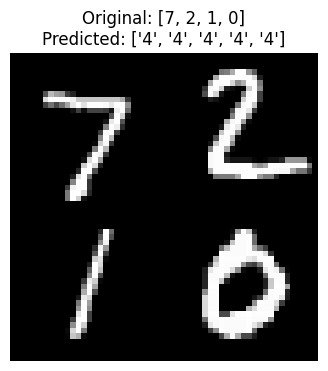

Image 1:
  Original digits: [4, 1, 4, 9]
  Predicted sequence: ['4', '4', '4', '4', '4']


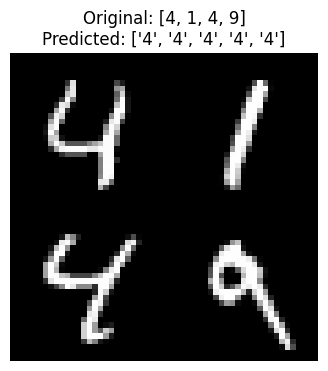

Image 2:
  Original digits: [5, 9, 0, 6]
  Predicted sequence: ['8', '4', '8', '4', 'EOS']


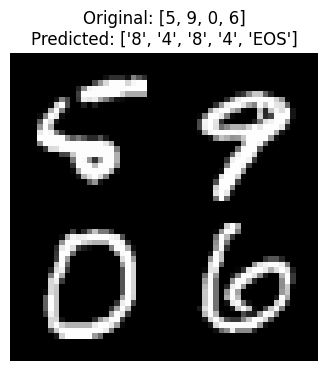

Image 3:
  Original digits: [9, 0, 1, 5]
  Predicted sequence: ['4', '8', '4', '4', 'EOS']


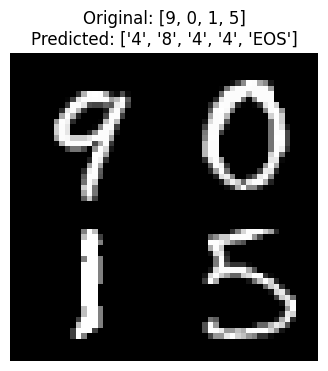

In [ ]:
# Get a single batch and run the trained model in inference mode
fusion_factor = 4
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Calculate height and width of patch grid after fusion
if fusion_factor == 1:
    # Standard MNIST - 4×4 grid of patches (16 total)
    patch_height = 4
    patch_width = 4
elif fusion_factor == 4:
    # 2×2 grid of MNIST images = 8×8 grid of patches (64 total)
    patch_height = 8
    patch_width = 8
elif fusion_factor == 16:
    # 4×4 grid of MNIST images = 16×16 grid of patches (256 total)
    patch_height = 16
    patch_width = 16
else:
    raise ValueError(f"Unsupported fusion_factor: {fusion_factor}")

# Initialize position embedding with correct dimensions
pos_embedding = LearnablePosition2DEmbedding(
    height=patch_height,  # Use calculated patch_height
    width=patch_width,  # Use calculated patch_width
    embed_dim=embed_dim
).to(device)

# Filter to ensure batch size is divisible by fusion factor
batch_size = images.shape[0]
if batch_size % fusion_factor != 0:
    # Trim to nearest multiple of fusion_factor
    images = images[:batch_size - (batch_size % fusion_factor)]
    labels = labels[:batch_size - (batch_size % fusion_factor)]

# Prepare the input
fused_images = fuse_images(images, fusion_factor).to(device)
patches = image_to_patches(fused_images, patch_size=7)
reduced_patches = dim_reducer(patches).float()
reduced_patches = pos_embedding(reduced_patches)

# Run inference
model.eval()
with torch.no_grad():
    predictions = model(reduced_patches)

# Display results
for i in range(fused_images.size(0)):
    # Get original labels
    original_indices = list(range(i*fusion_factor, (i+1)*fusion_factor))
    original_digits = [labels[j].item() for j in original_indices]

    # Get predicted sequence (remove any EOS/PAD tokens)
    pred_sequence = []
    for token in predictions[i].cpu().tolist():
        if token == model.EOS_TOKEN:
            pred_sequence.append("EOS")
            break
        elif token == model.PAD_TOKEN:
            pred_sequence.append("PAD")
        else:
            pred_sequence.append(str(token))

    print(f"Image {i}:")
    print(f"  Original digits: {original_digits}")
    print(f"  Predicted sequence: {pred_sequence}")

    # Optionally display the image
    plt.figure(figsize=(4, 4))
    plt.imshow(fused_images[i].cpu().permute(1, 2, 0).squeeze(), cmap='gray')
    plt.title(f"Original: {original_digits}\nPredicted: {pred_sequence}")
    plt.axis('off')
    plt.show()

In [ ]:
# After training is complete, save the model
model_path = "/content/drive/MyDrive/VIT_MNIST_FourHead_EncoderDecoder_20Epochs.pth"

# Create a dictionary with model state and any other info you want to save
checkpoint = {
    'model_state_dict': model.state_dict(),
    'dim_reducer_state_dict': dim_reducer.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': num_epochs,
    'embed_dim': 32,
    'patch_size': 7
}

# Save to Google Drive
torch.save(checkpoint, model_path)
print(f"Model saved to {model_path}")

# To load the model later:
"""
checkpoint = torch.load(model_path)
model = TransformerEncoderBlock(embed_dim=checkpoint['embed_dim']).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
dim_reducer = PatchDimReducer(in_features=49, out_features=checkpoint['embed_dim']).to(device)
dim_reducer.load_state_dict(checkpoint['dim_reducer_state_dict'])
"""

Model saved to /content/drive/MyDrive/VIT_MNIST_FourHead_EncoderDecoder_20Epochs.pth


"\ncheckpoint = torch.load(model_path)\nmodel = TransformerEncoderBlock(embed_dim=checkpoint['embed_dim']).to(device)\nmodel.load_state_dict(checkpoint['model_state_dict'])\ndim_reducer = PatchDimReducer(in_features=49, out_features=checkpoint['embed_dim']).to(device)\ndim_reducer.load_state_dict(checkpoint['dim_reducer_state_dict'])\n"

In [ ]:
# Test function
raise SystemExit("Skipping this cell.")

def test_seq2seq(model, dim_reducer, pos_embedding, test_loader,
                fusion_factor=4, patch_size=7, device='cuda'):

    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            batch_size = images.shape[0]

            # Skip incomplete batches
            if batch_size % fusion_factor != 0:
                continue

            # Fuse images
            fused_images = fuse_images(images, fusion_factor).to(device)

            # Create digit lists from labels for reference
            digit_lists = []
            for i in range(0, batch_size, fusion_factor):
                digit_lists.append(labels[i:i+fusion_factor].tolist())

            # Process images for encoder
            patches = image_to_patches(fused_images, patch_size=patch_size)
            reduced_patches = dim_reducer(patches).float()
            reduced_patches = pos_embedding(reduced_patches)

            # Generate sequences (inference mode without teacher forcing)
            predictions = model(reduced_patches)

            # Store results for evaluation
            for i, pred_seq in enumerate(predictions):
                # Convert to list and stop at EOS token
                pred_list = []
                for token in pred_seq.cpu().tolist():
                    if token == model.EOS_TOKEN:
                        break
                    pred_list.append(token)

                all_predictions.append(pred_list)
                all_targets.append(digit_lists[i])

    # Calculate sequence accuracy (exact match)
    correct = sum(1 for pred, target in zip(all_predictions, all_targets) if pred == target)
    total = len(all_predictions)
    sequence_accuracy = 100 * correct / total if total > 0 else 0

    # Calculate digit accuracy
    digit_correct = 0
    digit_total = 0
    for pred, target in zip(all_predictions, all_targets):
        # Compare up to the length of the shorter sequence
        min_len = min(len(pred), len(target))
        digit_correct += sum(1 for i in range(min_len) if pred[i] == target[i])
        digit_total += max(len(pred), len(target))  # Count extra or missing digits as errors

    digit_accuracy = 100 * digit_correct / digit_total if digit_total > 0 else 0

    print(f'Test Results:')
    print(f'  Sequence Accuracy: {sequence_accuracy:.2f}%')
    print(f'  Digit Accuracy: {digit_accuracy:.2f}%')

    # Show some examples
    print("\nExample predictions:")
    for i in range(min(5, len(all_predictions))):
        print(f"Target: {all_targets[i]}, Prediction: {all_predictions[i]}")

    return sequence_accuracy, digit_accuracy